In [8]:
import os, getpass
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"Box this lap, box for hards.", name="RaceEngineer")]
messages.append(HumanMessage(f"Copy that.", name="Driver"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: RaceEngineer

Box this lap, box for hards.
================================ Human Message =================================
Name: Driver

Copy that.


In [10]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4.1-nano")
llm.invoke(messages)

AIMessage(content='Understood. Coming into the pits for a tire change to hard compounds.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 28, 'total_tokens': 43, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_950f36939b', 'id': 'chatcmpl-CTM5BGThyktmjL9gpFpkyLUuqvF62', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--9a523c43-1da6-4239-acd7-e1cfe37e6d9a-0', usage_metadata={'input_tokens': 28, 'output_tokens': 15, 'total_tokens': 43, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

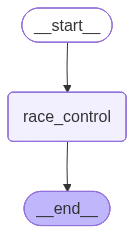

In [11]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

def race_control_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

builder = StateGraph(MessagesState)
builder.add_node("race_control", race_control_node)
builder.add_edge(START, "race_control")
builder.add_edge("race_control", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: RaceEngineer

Box this lap, box for hards.
================================ Human Message =================================
Name: Driver

Copy that.
================================== Ai Message ==================================

Understood, stay focused and prepare for the pit stop.


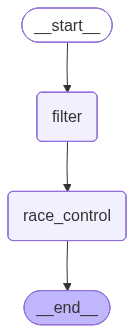

In [13]:
from langchain_core.messages import RemoveMessage

def filter_radio_messages(state: MessagesState):
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def race_control_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node("filter", filter_radio_messages)
builder.add_node("race_control", race_control_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "race_control")
builder.add_edge("race_control", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
messages = [AIMessage("Track limits warning, turn 5.", name="RaceControl", id="msg1")]
messages.append(HumanMessage("Copy.", name="Driver", id="msg2"))
messages.append(AIMessage("Push now, push now.", name="RaceEngineer", id="msg3"))
messages.append(HumanMessage("Understood, tyres are good.", name="Driver", id="msg4"))

output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: RaceEngineer

Push now, push now.
================================ Human Message =================================
Name: Driver

Understood, tyres are good.
================================== Ai Message ==================================

Great to hear the tires are in good shape. Keep monitoring the temperature and pressure, and stay focused on your lap. Let me know if you need any adjustments or if there's anything else.


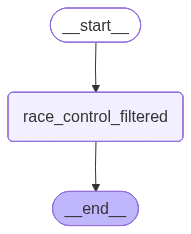

In [15]:
def race_control_node_filtered(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

builder = StateGraph(MessagesState)
builder.add_node("race_control_filtered", race_control_node_filtered)
builder.add_edge(START, "race_control_filtered")
builder.add_edge("race_control_filtered", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"What's the gap to the car behind?", name="Driver"))

In [17]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: RaceControl

Track limits warning, turn 5.
================================ Human Message =================================
Name: Driver

Copy.
================================== Ai Message ==================================
Name: RaceEngineer

Push now, push now.
================================ Human Message =================================
Name: Driver

Understood, tyres are good.
================================== Ai Message ==================================

Great to hear the tires are in good shape. Keep monitoring the temperature and pressure, and stay focused on your lap. Let me know if you need any adjustments or if there's anything else.
================================ Human Message =================================
Name: Driver

What's the gap to the car behind?


In [18]:
output_filtered = graph.invoke({'messages': messages})
for m in output_filtered['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: RaceControl

Track limits warning, turn 5.
================================ Human Message =================================
Name: Driver

Copy.
================================== Ai Message ==================================
Name: RaceEngineer

Push now, push now.
================================ Human Message =================================
Name: Driver

Understood, tyres are good.
================================== Ai Message ==================================

Great to hear the tires are in good shape. Keep monitoring the temperature and pressure, and stay focused on your lap. Let me know if you need any adjustments or if there's anything else.
================================ Human Message =================================
Name: Driver

What's the gap to the car behind?
================================== Ai Message ==================================

To determine the gap to the car behind, you'

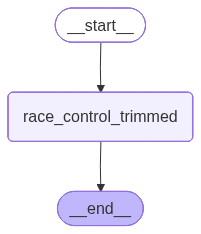

In [19]:
from langchain_core.messages import trim_messages

def race_control_node_trimmed(state: MessagesState):
    trimmed = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(trimmed)]}

builder = StateGraph(MessagesState)
builder.add_node("race_control_trimmed", race_control_node_trimmed)
builder.add_edge(START, "race_control_trimmed")
builder.add_edge("race_control_trimmed", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
messages.append(output_filtered['messages'][-1])
messages.append(HumanMessage(f"Is rain expected?", name="Driver"))

In [21]:
trimmed_example = trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )
trimmed_example

[HumanMessage(content='Is rain expected?', additional_kwargs={}, response_metadata={}, name='Driver')]

In [22]:
messages_out_trim = graph.invoke({'messages': messages})